# Passive Hopper(Ground)

In [7]:
%pip install ipympl mplcursors -q
%matplotlib widget

Note: you may need to restart the kernel to use updated packages.


In [8]:
import os
# Get current working directory
cwd = os.getcwd()

# Only go up one level if we’re currently inside 'notebooks'
if cwd.endswith("notebooks"):
    os.chdir("..")
print("Current working directory:", os.getcwd())

Current working directory: /Users/jerrywumacmini/Desktop/hopper_sim


In [9]:
import yaml

with open("cfg/passive_hopper.yaml", "r") as f:
    cfg = yaml.safe_load(f)

m_b = cfg["body_mass"]
m_l = cfg["leg_mass"]
l0 = cfg["spring_length"]
k = cfg["spring_constant"]
g = cfg["gravity"]
x0 = cfg["x0"]

In [10]:
print(f"Body mass: {m_b}, Leg mass: {m_l}, Spring length: {l0}, Spring constant: {k}, Gravity: {g}, Initial state: {x0}")

Body mass: 1, Leg mass: 0.2, Spring length: 0.3, Spring constant: 800, Gravity: 9.81, Initial state: [0.25, 0.0, 0.0, 0.0]


## Two States State Machine

Initial state: stance


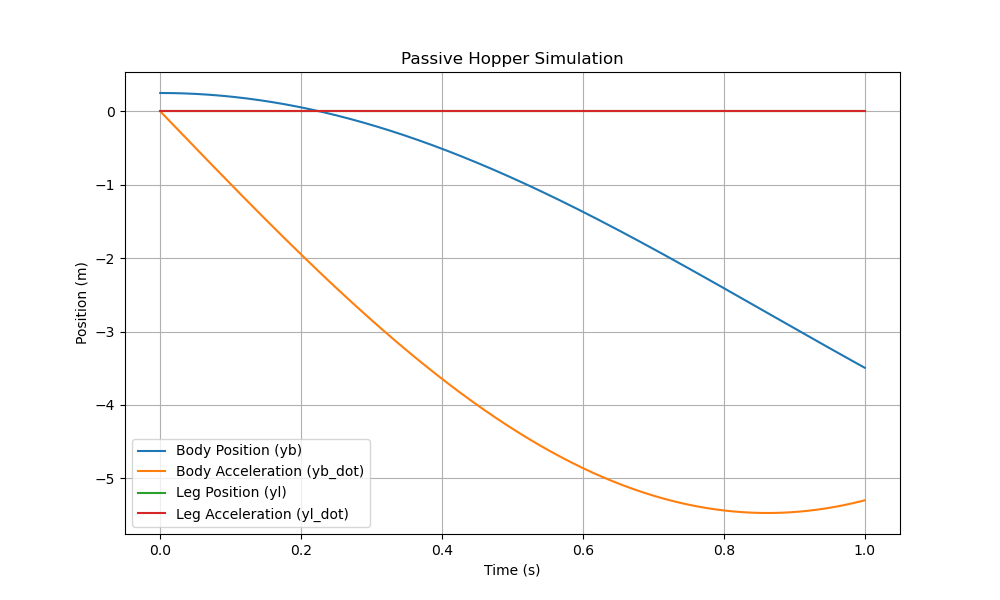

In [11]:
import numpy as np
from dynamics.passive_hopper import flight_mode, stance_mode

# --- Simulation ---
dt = 0.001
t_max = 1.0
steps = int(t_max / dt)
t = np.linspace(0, t_max, steps)

# initial state
x = np.zeros((steps, 4))
x[0] = x0

if x0[2] > 0:
    state = "flight"
else:
    state = "stance"

print(f"Initial state: {state}")

for i in range(1, steps):
    if state == "flight":
        x_dot = flight_mode(x[i-1], m_b, m_l, l0, k, g)
        x[i] = x[i-1] + x_dot * dt
        if x[i][2] <= 1e-4 and x[i][3] <= 1e-4:
            state = "stance"
            x[i][2] = 0  # ensure leg position is at ground level
    elif state == "stance":
        x_dot = stance_mode(x[i-1], m_b, m_l, l0, k, g)
        x[i] = x[i-1] + x_dot * dt
        if x[i][2] > 0:
            state = "flight"

# --- Plotting ---
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(t, x[:, 0], label='Body Position (yb)')
ax.plot(t, x[:, 1], label='Body Acceleration (yb_dot)')
ax.plot(t, x[:, 2], label='Leg Position (yl)')
ax.plot(t, x[:, 3], label='Leg Acceleration (yl_dot)')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Position (m)')
ax.set_title('Passive Hopper Simulation')
ax.legend()
ax.grid(True)

plt.show()

Simulate:

NameError: name 'yb' is not defined

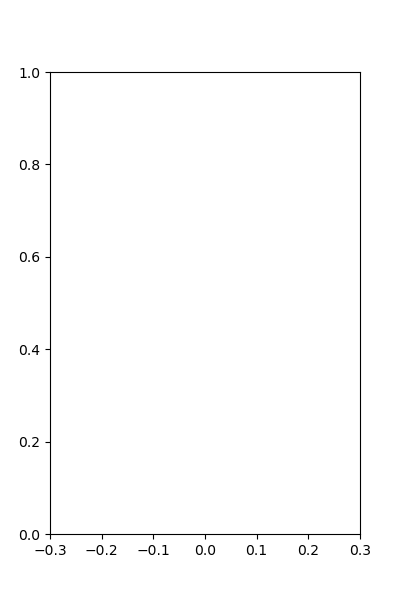

In [12]:
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Rectangle
from IPython.display import HTML

# --- Animation setup ---
fig, ax = plt.subplots(figsize=(4,6))
ax.set_xlim(-0.3, 0.3)
ax.set_ylim(-0.1, max(yb) + 0.2)
ax.set_xlabel("X (fixed)")
ax.set_ylabel("Height (m)")
ax.set_title("1D Two-Mass Spring Hopper")

# --- Define body and leg as rectangles ---
body_height, leg_height = 0.05, 0.05
body_width, leg_width = 0.15, 0.15

body_rect = Rectangle((-body_width/2, yb[0]-body_height/2), body_width, body_height,
                      fc='royalblue', label='Body')
leg_rect = Rectangle((-leg_width/2, yl[0]-leg_height/2), leg_width, leg_height,
                     fc='orangered', label='Leg')

ax.add_patch(body_rect)
ax.add_patch(leg_rect)
spring_line, = ax.plot([0, 0], [yl[0], yb[0]], '-', color='green', lw=2)
ax.legend()

def init():
    body_rect.set_xy((-body_width/2, yb[0]-body_height/2))
    leg_rect.set_xy((-leg_width/2, yl[0]-leg_height/2))
    spring_line.set_data([0, 0], [yl[0], yb[0]])
    return body_rect, leg_rect, spring_line

def update(i):
    # update body position
    body_rect.set_xy((-body_width/2, yb[i]-body_height/2))
    # update leg position
    leg_rect.set_xy((-leg_width/2, yl[i]-leg_height/2))
    # update spring
    spring_line.set_data([0, 0], [yl[i], yb[i]])
    return body_rect, leg_rect, spring_line

ani = FuncAnimation(
    fig,
    update,
    frames=range(0, steps, 5),
    init_func=init,
    blit=True,
    interval=dt*1000
)

HTML(ani.to_jshtml())
